In [1]:
%load_ext autoreload
%autoreload 2

from typing import List, Dict

import sys
import yaml
sys.path.append('.')
sys.path.append('..')

import time
from tqdm import tqdm
from pathlib import Path

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import datasets
import eval
import models.diffusion
from models.diffusion_utils import generate
from models.train_utils import create_input_iter

from ml_collections.config_dict import ConfigDict

%matplotlib inline
plt.style.use('/mnt/home/tnguyen/default.mplstyle')

2024-01-03 13:48:58.914654: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-03 13:48:58.914710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-03 13:48:58.916074: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-03 13:48:58.925249: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-03 13:49:00.797787: W tensorflow/comp

In [59]:
path_to_model = Path("/mnt/ceph/users/tnguyen/dark_camels/point-cloud-diffusion-logging/"\
    "cosmology/gallant-bush-49")

# load the samples
true_samples = np.load(path_to_model / "true_samples.npy")
generated_samples = np.load(path_to_model / "generated_samples.npy")
conditioning_samples = np.load(path_to_model / "conditioning_samples.npy")

## Comparing distribution

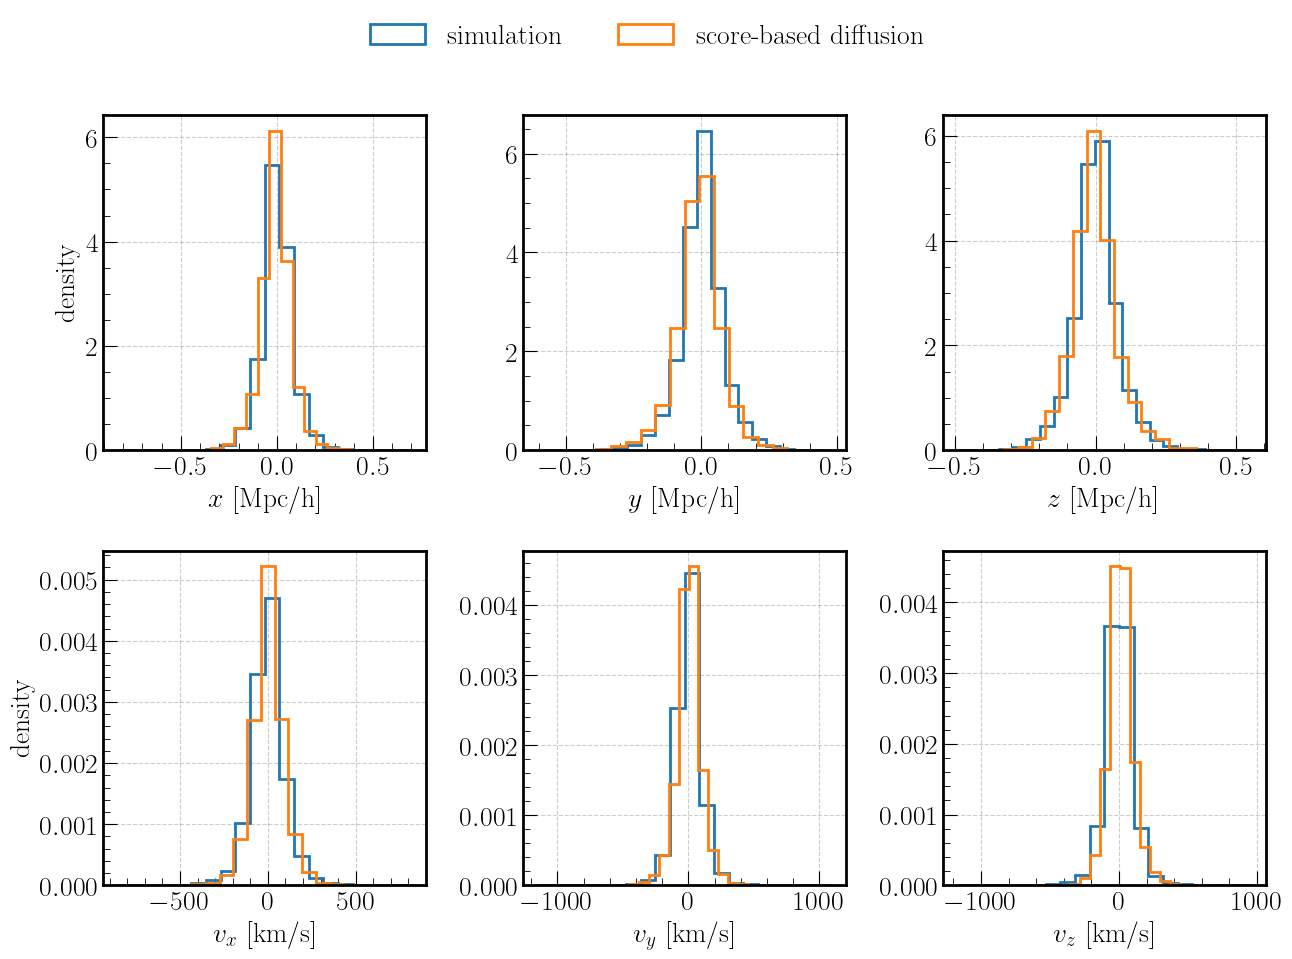

In [60]:
# compare the distribution
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

bins = 20
for i, ax in enumerate(axes.ravel()):
    ax.hist(
        true_samples[..., i].ravel(), density=True, bins=bins,
        color='C0', histtype='step', label='simulation', lw=2)
    ax.hist(
        generated_samples[..., i].ravel(), density=True, bins=bins,
        color='C1', histtype='step', label='score-based diffusion', lw=2)

axes[0, 0].set_xlabel(r'$x$ [Mpc/h]')
axes[0, 1].set_xlabel(r'$y$ [Mpc/h]')
axes[0, 2].set_xlabel(r'$z$ [Mpc/h]')
axes[1, 0].set_xlabel(r'$v_x$ [km/s]')
axes[1, 1].set_xlabel(r'$v_y$ [km/s]')
axes[1, 2].set_xlabel(r'$v_z$ [km/s]')
axes[0, 0].set_ylabel(r'density')
axes[1, 0].set_ylabel(r'density')

# create handles
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(
    handles, labels, loc='upper center', ncol=2, fontsize=20)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

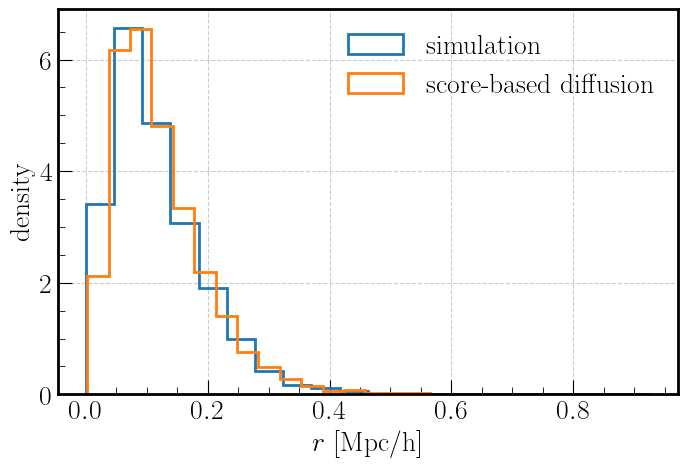

In [61]:
# compare the distribution
fig, ax = plt.subplots(1, figsize=(8, 5))

bins = 20
true_samples_rad = np.sqrt(np.sum(true_samples[..., :3]**2, axis=-1))
generated_samples_rad = np.sqrt(np.sum(generated_samples[..., :3]**2, axis=-1))

ax.hist(
    true_samples_rad.ravel(), density=True, bins=bins,
    color='C0', histtype='step', label='simulation', lw=2)
ax.hist(
    generated_samples_rad.ravel(), density=True, bins=bins,
    color='C1', histtype='step', label='score-based diffusion', lw=2)
ax.set_xlabel(r'$r$ [Mpc/h]')
ax.set_ylabel(r'density')

# create handles
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles, labels, loc=1, fontsize=20)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

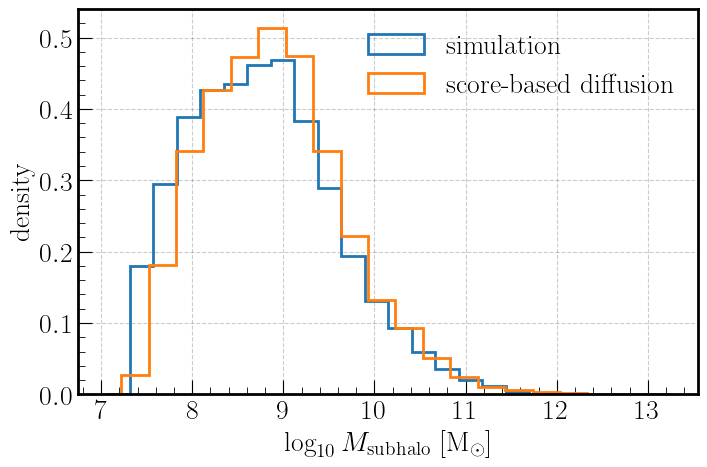

In [62]:
if true_samples.shape[-1] == 7:
    fig, ax = plt.subplots(1, figsize=(8, 5))

    bins = 20
    ax.hist(
        true_samples[..., -1].ravel(), density=True, bins=bins,
        color='C0', histtype='step', label='simulation', lw=2)
    ax.hist(
        generated_samples[..., -1].ravel(), density=True, bins=bins,
        color='C1', histtype='step', label='score-based diffusion', lw=2)
    ax.set_xlabel(r'$\log_{10} M_{\rm subhalo}$ [M$_\odot$]')
    ax.set_ylabel(r'density')

    # create handles
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles, labels, loc=1, fontsize=20)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()

## Projection of the generated samples

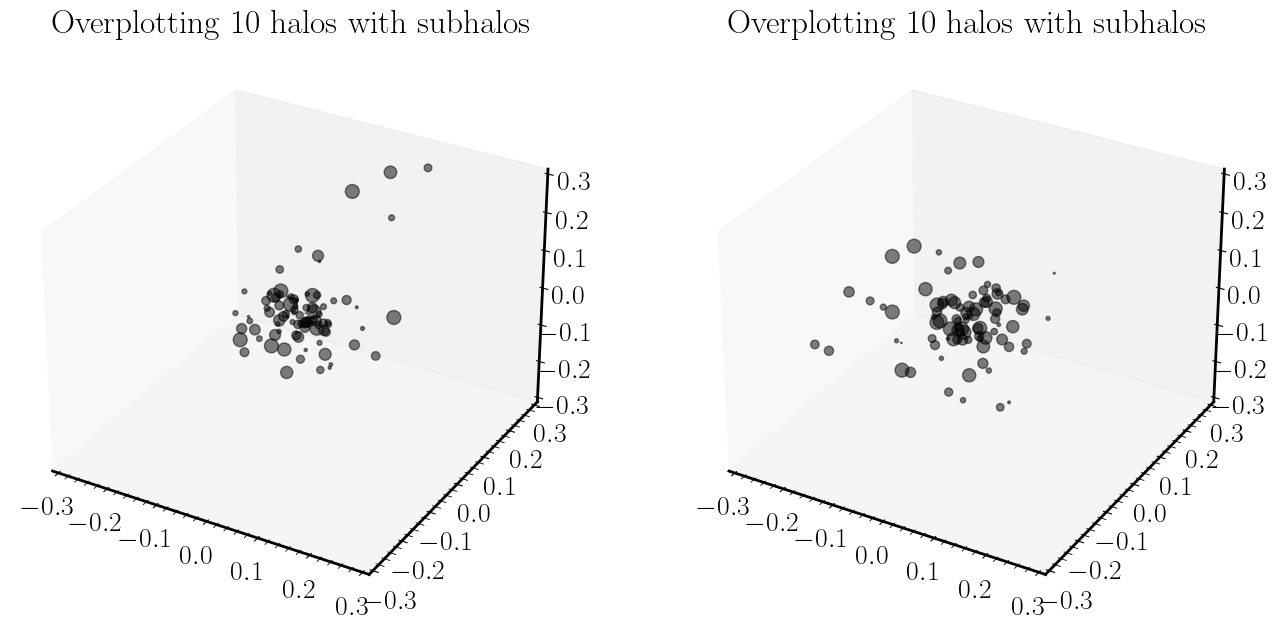

In [63]:
# plot the 3D positions of the subhalos
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

num_plots = 10

for halo_idx in range(num_plots):
    subhalo_pos = true_samples[halo_idx, :, :3]
    if true_samples.shape[-1] == 7:
        subhalo_mass = true_samples[halo_idx, :, -1]
    else:
        subhalo_mass = np.ones(subhalo_pos.shape[0])

    # get the normalized subhalo mass
    # normalize to [0, 1] range 
    s = np.log10(subhalo_mass)
    s = (s - s.min()) / (s.max() - s.min()) * 100
    ax1.scatter(
        subhalo_pos[:, 0], subhalo_pos[:, 1], subhalo_pos[:, 2],
        s=s, c='k', alpha=0.5)

    subhalo_pos = generated_samples[halo_idx, :, :3]
    if generated_samples.shape[-1] == 7:
        subhalo_mass = generated_samples[halo_idx, :, -1]
    else:
        subhalo_mass = np.ones(subhalo_pos.shape[0])
    # get the normalized subhalo mass
    # normalize to [0, 1] range 
    s = np.log10(subhalo_mass)
    s = (s - s.min()) / (s.max() - s.min()) * 100
    ax2.scatter(
        subhalo_pos[:, 0], subhalo_pos[:, 1], subhalo_pos[:, 2],
        s=s, c='k', alpha=0.5)


# ax1.set_xlabel('x [Mpc/h]', labelpad=20)
# ax1.set_ylabel('y [Mpc/h]', labelpad=20)
# ax1.set_zlabel('z [Mpc/h]', labelpad=20)
ax1.set_title(f'Overplotting {num_plots} halos with subhalos')
ax2.set_title(f'Overplotting {num_plots} halos with subhalos')

# aspect ratio of the plot
max_range = 0.3
ax1.set_xlim(-max_range, max_range)
ax1.set_ylim(-max_range, max_range)
ax1.set_zlim(-max_range, max_range)
ax2.set_xlim(-max_range, max_range)
ax2.set_ylim(-max_range, max_range)
ax2.set_zlim(-max_range, max_range)

ax1.grid(False)
ax2.grid(False)


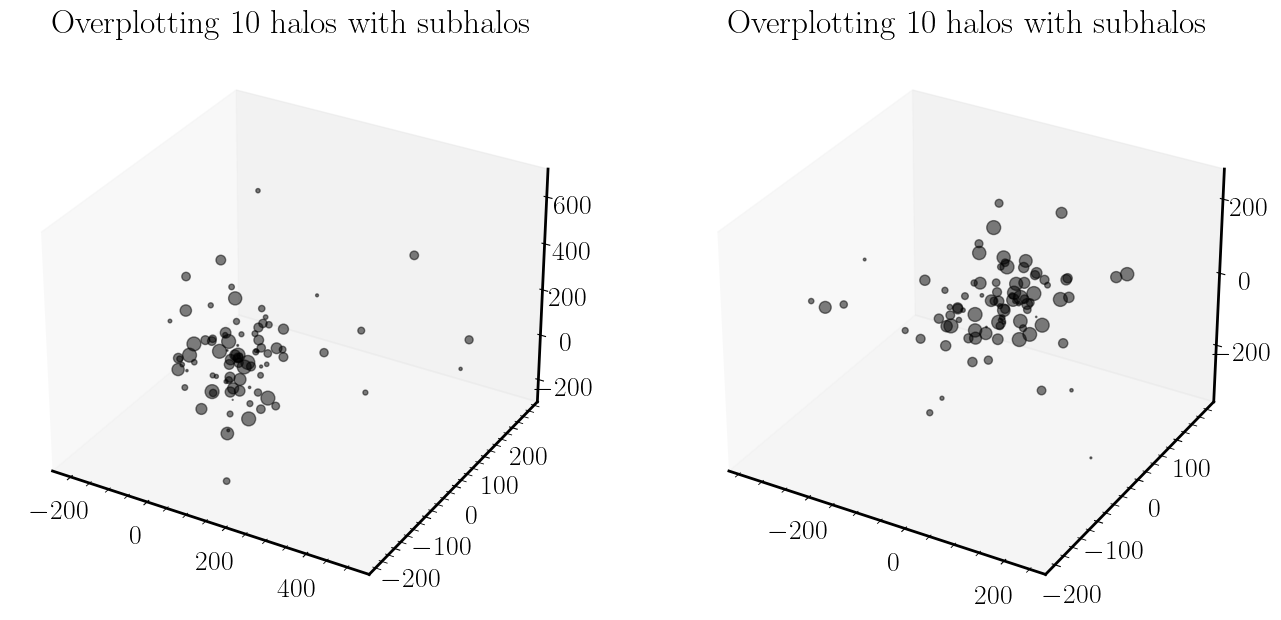

In [64]:
# plot the 3D positions of the subhalos
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

num_plots = 10

for halo_idx in range(num_plots):
    subhalo_pos = true_samples[halo_idx, :, 3:6]
    if true_samples.shape[-1] == 7:
        subhalo_mass = true_samples[halo_idx, :, -1]
    else:
        subhalo_mass = np.ones(subhalo_pos.shape[0])

    # get the normalized subhalo mass
    # normalize to [0, 1] range 
    s = np.log10(subhalo_mass)
    s = (s - s.min()) / (s.max() - s.min()) * 100
    ax1.scatter(
        subhalo_pos[:, 0], subhalo_pos[:, 1], subhalo_pos[:, 2],
        s=s, c='k', alpha=0.5)

    subhalo_pos = generated_samples[halo_idx, :, 3:6]
    if generated_samples.shape[-1] == 7:
        subhalo_mass = generated_samples[halo_idx, :, -1]
    else:
        subhalo_mass = np.ones(subhalo_pos.shape[0])
    # get the normalized subhalo mass
    # normalize to [0, 1] range 
    s = np.log10(subhalo_mass)
    s = (s - s.min()) / (s.max() - s.min()) * 100
    ax2.scatter(
        subhalo_pos[:, 0], subhalo_pos[:, 1], subhalo_pos[:, 2],
        s=s, c='k', alpha=0.5)


# ax1.set_xlabel('x [Mpc/h]', labelpad=20)
# ax1.set_ylabel('y [Mpc/h]', labelpad=20)
# ax1.set_zlabel('z [Mpc/h]', labelpad=20)
ax1.set_title(f'Overplotting {num_plots} halos with subhalos')
ax2.set_title(f'Overplotting {num_plots} halos with subhalos')

# aspect ratio of the plot
# max_range = 0.3
# ax1.set_xlim(-max_range, max_range)
# ax1.set_ylim(-max_range, max_range)
# ax1.set_zlim(-max_range, max_range)
# ax2.set_xlim(-max_range, max_range)
# ax2.set_ylim(-max_range, max_range)
# ax2.set_zlim(-max_range, max_range)

ax1.grid(False)
ax2.grid(False)


### Density profiles

In [65]:
import jeansgnn_utils as jgnn_ut

In [66]:
true_samples_mass = 10**true_samples[:, :, -1]
true_samples_rad = np.sqrt(true_samples[..., :3]**2).sum(axis=-1)
generated_samples_mass = 10**generated_samples[:, :, -1]
generated_samples_rad = np.sqrt(generated_samples[..., :3]**2).sum(axis=-1)

/tmp/ipykernel_3132227/2603309034.py:12: RuntimeWarning: divide by zero encountered in log10
  log_rho = np.log10(rho)
/tmp/ipykernel_3132227/2603309034.py:22: RuntimeWarning: divide by zero encountered in log10
  log_rho = np.log10(rho)


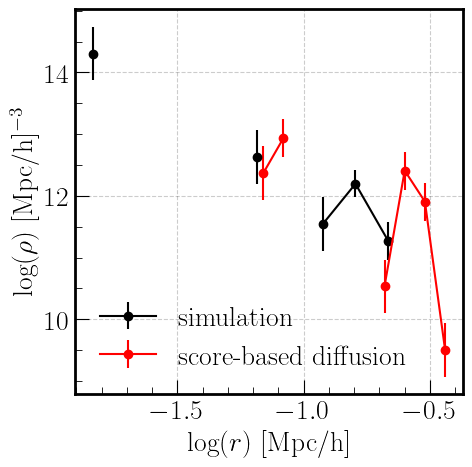

In [79]:
# r_min = 0.01
# r_max = 100
r_min, r_max = None, None
index = 5
num_bins = 10

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

rho, rho_sigma, logr_bins = jgnn_ut.particles.calc_rho(
    true_samples_rad[index], true_samples_mass[index], 
    r_min=r_min, r_max=r_max, num_bins=num_bins)
log_rho = np.log10(rho)
sigma_rho = rho_sigma / rho / np.log(10)
logr_ce = 0.5 * (logr_bins[1:] + logr_bins[:-1])
ax.errorbar(
    logr_ce, log_rho, yerr=sigma_rho, fmt='o-', c='k', 
    label='simulation')

rho, rho_sigma, logr_bins = jgnn_ut.particles.calc_rho(
    generated_samples_rad[index], generated_samples_mass[index],
    r_min=r_min, r_max=r_max, num_bins=num_bins)
log_rho = np.log10(rho)
sigma_rho = rho_sigma / rho / np.log(10)
logr_ce = 0.5 * (logr_bins[1:] + logr_bins[:-1])
ax.errorbar(
    logr_ce, log_rho, yerr=sigma_rho, fmt='o-', c='r', 
    label='score-based diffusion')

ax.set_xlabel(r'$\log(r)$ [Mpc/h]')
ax.set_ylabel(r'$\log(\rho)$ [Mpc/h]$^{-3}$')
ax.legend()

plt.show()